In [ ]:
from collections import defaultdict
from pathlib import Path

import equinox as eqx
import jax
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    root_mean_squared_error as root_mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.models import NeuralODE
from ott.utils import batched_vmap
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

EXP_TYPES_ALL = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    "neighborhood",
    "normal",
    "proxy_tangent_evolution",
)
EXP_TYPES = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    # "proxy_tangent_evolution",
    # "neighborhood",
)
COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        ("royalblue", "limegreen", "darkorange", "orangered", "saddlebrown", "purple"),
    )
)
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Vanilla",
            "Jacobian matching",
            "Tangent Evolution matching",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
            "Identity (ours)",
        ),
    )
)

In [10]:
downsample = 2
noise = 0.0
train_length = 2

datadir = Path("../../data")

dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large_test.hdf5")
    .downsample(downsample)
    .add_noise(0.0)
    .apply_transform(transform)
)


In [12]:
def load_experiment(
    exp_type: str,
    key: int,
    downsample: int = 2,
    train_length: int = 2,
    noise: float = 0.0,
    model_type: str = "neuralode",
    rootdir=Path("../../results/smaller_datasets/50_500/lorenz63"),
) -> NeuralODE:
    loaddir = rootdir / f"downsample={downsample}/len={train_length}/{exp_type}"
    if exp_type == "neighborhood":
        loaddir = loaddir / "weight=1.0/neighbors=30"
    elif exp_type == "proxy_tangent_evolution":
        loaddir = loaddir / "weight=0.001"
    if model_type != "neuralode":
        loaddir = loaddir / model_type  # / "len=10"
    model_paths = list(loaddir.glob(f"*lr=0.002_noise={noise}_key={key}*"))
    if len(model_paths) == 0:
        raise ValueError("No models found with the given conditions")
    elif len(model_paths) > 1:
        raise ValueError("Multiple models found with the given conditions!")
    else:
        return load_model(model_paths[0])


In [13]:
key = 0
traj_idx = 100
t_traj, u_traj = dataset_test[traj_idx]

n_short = 750
t_short_norm = np.arange(n_short) * 0.01
t_short, u_short = t_traj[:n_short], u_traj[:n_short]

u_short_dict = defaultdict(list)
for model_type in tqdm(("neuralode", "lstm")):
    model = load_experiment(
        "tangent_evolution", key, noise=noise, model_type=model_type
    )
    u_short_dict[model_type] = model.solve(t_short, u_short[0])

100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Text(0.5, 0.98, 'Short term predictions: train_length=2, seed=0')

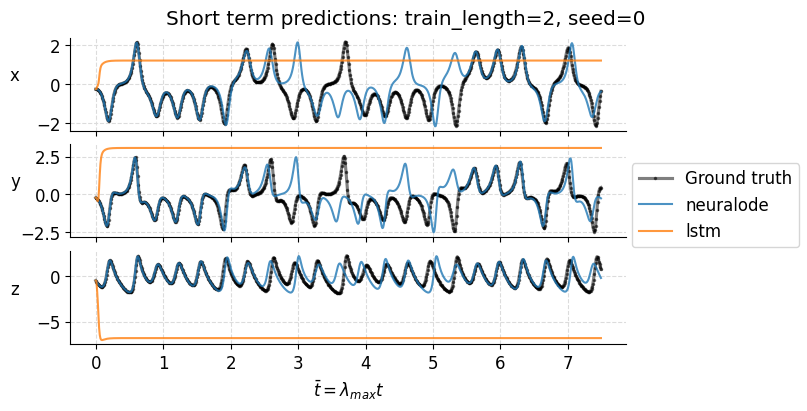

In [14]:
plot_kwargs = {"linewidth": 1.5, "alpha": 0.8}

fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
for i, (ax, y_name) in enumerate(zip(axes.flat, ("x", "y", "z"))):
    ax.plot(
        t_short_norm,
        u_short[:, i],
        ".-",
        color="black",
        linewidth=2.25,
        alpha=0.5,
        label="Ground truth",
    )
    for model_type, u_pred in u_short_dict.items():
        ax.plot(
            t_short_norm,
            u_pred[:, i],
            label=model_type,
            **plot_kwargs,
        )
    ax.set_ylabel(y_name, rotation="horizontal")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
fig.align_ylabels()
fig.legend(
    *ax.get_legend_handles_labels(), loc="outside center right", fontsize="medium"
)
fig.suptitle(f"Short term predictions: {train_length=}, seed={key}", fontsize="large")

In [17]:
key = 0
traj_idx = 50
t_traj, u_traj = dataset_test[traj_idx]

# n_short = 750
#
t_short, u_short = t_traj, u_traj


u_long_dict = defaultdict(list)
for model_type in tqdm(("neuralode", "lstm")):
    model = load_experiment(
        "tangent_evolution", key, noise=noise, model_type=model_type
    )
    u_long_dict[model_type] = model.solve(t_short, u_short[0])

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


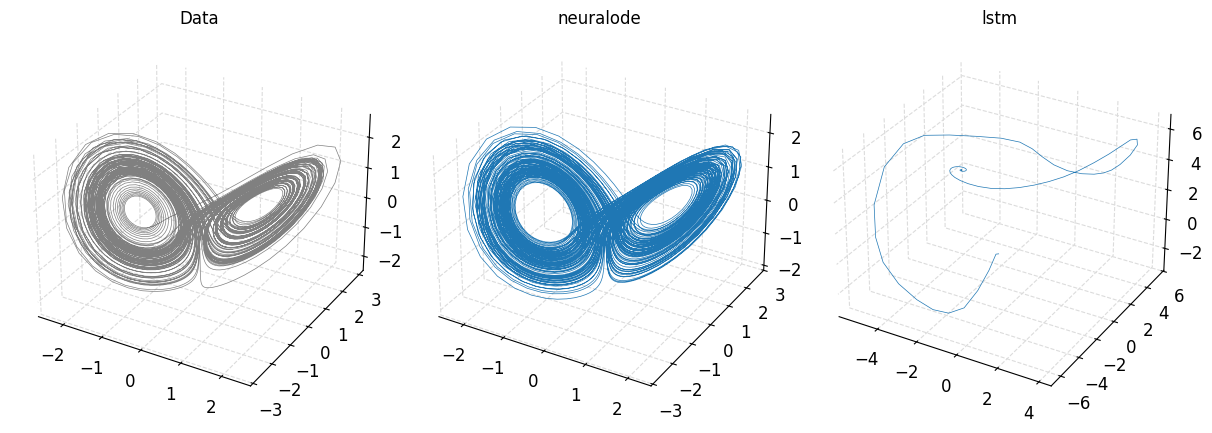

In [18]:
fig, axes = plt.subplots(
    1, len(u_long_dict) + 1, figsize=(12, 7), subplot_kw={"projection": "3d"}
)
plot_kwargs = {"linewidth": 0.5}
axes[0].plot(*u_traj.T, color="gray", **plot_kwargs)
axes[0].set_title("Data", fontsize="medium")
for i, (model_type, u_long) in enumerate(u_long_dict.items()):
    axes[i + 1].plot(*u_long.T, **plot_kwargs)
    axes[i + 1].set_title(label=model_type, fontsize="medium")


In [ ]:
idx_long = np.asarray([1, 5, 50, 500, 5000]) - 1
t_norm = np.arange(dataset_test.t.shape[0]) * 0.02
t_long, t_long_norm = dataset_test.t[0, idx_long], t_norm[idx_long]


@eqx.filter_jit
def solve_batch(model, t, u0_batch):
    def _solve(u0_):
        return model.solve(t, u0_)

    return batched_vmap(_solve, batch_size=5000)(u0_batch)


def calculate_metric_long(model, metric_fn=jax.jit(sinkhorn_divergence)):
    u_long_batch = dataset_test.u[:, idx_long]
    u_long_pred = solve_batch(model, t_long, u_long_batch[:, 0])
    print("Solve finished")
    metric = []
    for i in range(1, len(idx_long)):
        metric.append(metric_fn(u_long_batch[:, i], u_long_pred[:, i]))
    return np.asarray(metric)


metric_long_dict = defaultdict(list)
for model_type in tqdm(("neuralode", "lstm")):
    metric_long_dict[model_type] = [
        calculate_metric_long(
            load_experiment("vanilla", key, noise=noise, model_type=model_type)
        )
        for k in (0, 10, 20)
    ]

  0%|          | 0/2 [00:00<?, ?it/s]

Solve finished
Solve finished
Solve finished


 50%|█████     | 1/2 [01:07<01:07, 67.64s/it]

Solve finished
Solve finished
Solve finished


100%|██████████| 2/2 [01:53<00:00, 56.59s/it]


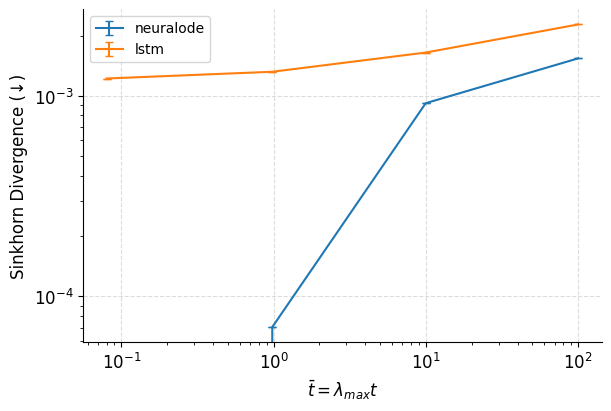

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for model_type, metric_long in metric_long_dict.items():
    ax.errorbar(
        t_long_norm[1:],
        np.mean(metric_long, axis=0),
        np.std(metric_long, axis=0),
        capsize=3,
        label=model_type,
    )
ax.legend(fontsize="small")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
ax.set_ylabel("Sinkhorn Divergence (↓)")
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)